In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from bokeh.io import output_notebook, show
from bokeh.plotting import figure, output_file
from bokeh.models import ColumnDataSource, Range1d
from bokeh.layouts import gridplot
from bokeh.models import LinearColorMapper, ColorBar
from bokeh.transform import transform
output_notebook()

plotpar = {'axes.labelsize': 30,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'legend.fontsize': 20,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Loading BokehJS ...

In [2]:
df = pd.read_csv("../data/bokeh_df.csv")

In [3]:
tic = pd.read_csv("data/TICv8_1_TIC_288735205.csv")
print(tic.plx)
# for k in tic.keys():
#     print(k)

0    8.43809
Name: plx, dtype: float64


In [62]:
Gmag = tic.GAIAmag.values[0]
teff = tic.Teff.values[0]
print(teff)
age = 2.4

def abs_mag(m, D):
    #  m - M = 5log(D) - 5
    return m - 5*np.log10(D) + 5
abs_G = abs_mag(Gmag, 1./tic.plx*1e3)

prot = 27

4699


In [63]:
source = ColumnDataSource(data=dict(teff=df.teff.values[::2], mg=df.M_G.values[::2], prot=df.prot.values[::2],
                                    age=df.kin_age.values[::2]))
# sun = ColumnDataSource(data=dict(teff=np.array([5777]), mg=np.array([4.67]), prot=np.array([26]),
#                                  age=np.array([4.56])))
star = ColumnDataSource(data=dict(teff=np.array([teff]), mg=np.array([abs_G]), prot=np.array([prot]),
                                  age=np.array([age])))

TOOLS = "box_select,lasso_select,help,reset"

# create a new plot and add a renderer
left = figure(tools=TOOLS, width=600, height=500, x_range=(7500, 3000), y_range=(11, -2))
color_mapper = LinearColorMapper(palette="Plasma256", low=0, high=10)

left.circle(x='teff', y='mg', color=transform('age', color_mapper), size=3, alpha=0.6, source=source)
left.circle(x='teff', y='mg', color=transform('age', color_mapper), line_color="black", size=15, alpha=1, source=star)
left.xaxis.axis_label = 'Teff [K]'
left.yaxis.axis_label = 'M_G'

# create another new plot and add a renderer
right = figure(tools=TOOLS, width=600, height=500, y_axis_type="log", x_range=(7500, 3000), y_range=(1, 80))

right.circle(x='teff', y='prot', color=transform('age', color_mapper), size=3, alpha=0.6, source=source)
right.circle(x='teff', y='prot', color=transform('age', color_mapper), line_color="black", size=15, alpha=1, source=star)
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0,0), title='Age [Gyr]')
right.add_layout(color_bar, 'right')

right.xaxis.axis_label = 'Teff [K]'
right.yaxis.axis_label = 'Prot [days]'

p = gridplot([[left, right]])

# output_file('Nick.html')

show(p)

In [61]:
import stardate as sd

# Create a dictionary of observables
iso_params = {"J": (float(tic.Jmag.values), float(tic.e_Jmag.values)),
              "H": (float(tic.Hmag.values), float(tic.e_Hmag.values)),
              "K": (float(tic.Kmag.values), float(tic.e_Kmag.values)),
              "G": (Gmag, float(tic.e_GAIAmag.values)),
              "BP": (float(tic.gaiabp.values), float(tic.e_gaiabp.values)),
              "RP": (float(tic.gaiarp.values), float(tic.e_gaiarp.values)),
              "parallax": (float(tic.plx.values), float(tic.e_plx.values))}
iso_params

{'J': (10.226, 0.021),
 'H': (9.715, 0.017),
 'K': (9.619, 0.018000000000000002),
 'G': (11.8104, 0.000852),
 'BP': (12.4022, 0.00243),
 'RP': (11.0998, 0.001159),
 'parallax': (8.438089999999999, 0.0266006)}

In [7]:
# prot, prot_err = 27, 5

# # Set up the star object.
# star = sd.Star(iso_params, prot=prot, prot_err=prot_err, Av=.01, Av_err=.2)

# # Run the MCMC
# star.fit(inits=[280, np.log10(4e9), 0, 1./(8.43809*1e-3), 0], max_n=10000, burnin=100)

In [8]:
# # Print the median age with the 16th and 84th percentile uncertainties.
# age, errp, errm, samples = star.age_results(burnin=100)
# print("stellar age = {0:.2f} + {1:.2f} + {2:.2f}".format(age, errp, errm))

In [9]:
# import corner
# corner.corner(star.samples);

In [11]:
import stardate2 as sd2

gp = sd2.GP_model()
print(gp.pred_at(np.log10(5e9), teff))

[27.52944654]


In [43]:
test_ages = np.linspace(9, 10, 9)
test_teffs = np.linspace(3000, 7000, 100)

prots = np.zeros((len(test_ages), len(test_teffs)))
for i, a in enumerate(test_ages):
    for j, t in enumerate(test_teffs):
        prots[i, j] = gp.pred_at(a, t)

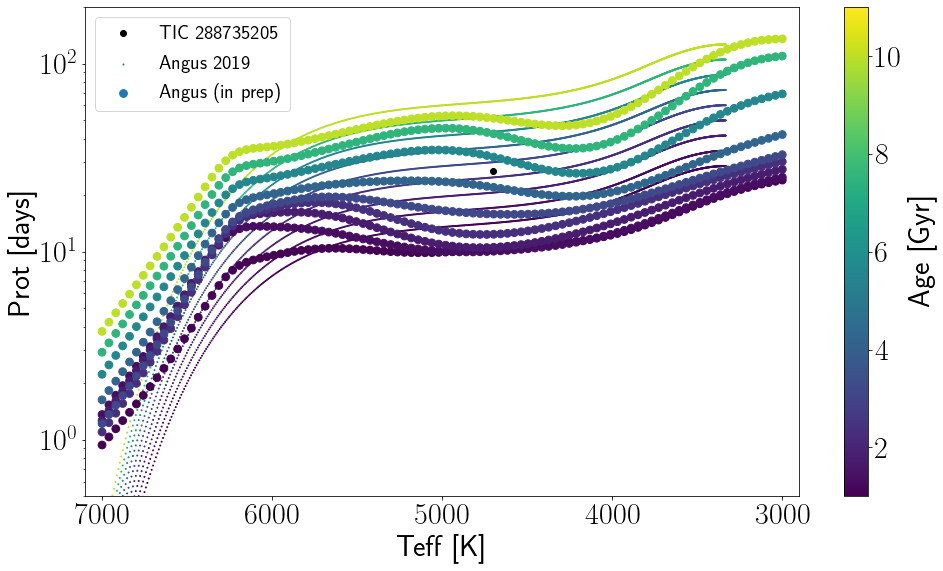

In [52]:
import kinematics_and_rotation as kr

plt.figure(figsize=(16, 9))

# logages = np.log10(np.arange(1, 10)*1e9)
bprps = np.linspace(.4, 2.7, 1000)
teffs = kr.bprp_to_teff(bprps)
for i, a in enumerate(test_ages[:-1]):
    _age = (10**test_ages[i])*1e-9
    plt.scatter(teffs, sd2.angus_2019_model(a, bprps), c=np.ones(len(teffs))*_age, s=1,
                vmin=1, vmax=11, zorder=0)
_age = (10**test_ages[-1])*1e-9
plt.scatter(teffs, sd2.angus_2019_model(test_ages[-1], bprps), c=np.ones(len(teffs))*_age, s=1,
            vmin=1, vmax=11, zorder=0, label="Angus 2019")

for i, p in enumerate(prots[:-1]):
    _age = (10**test_ages[i])*1e-9
    plt.scatter(test_teffs, p, c=np.ones(len(p))*_age, vmin=1, vmax=11, s=60,
               zorder=1)
_age = (10**test_ages[-1])*1e-9
plt.scatter(test_teffs, prots[-1], c=np.ones(len(p))*_age, vmin=1, vmax=11, s=60,
            zorder=1, label="Angus (in prep)")

plt.colorbar(label=("Age [Gyr]"))
plt.plot(teff, prot, "ko", label="TIC 288735205")

plt.gca().invert_xaxis()
plt.yscale("log")
plt.xlabel("Teff [K]")
plt.ylabel("Prot [days]")
plt.ylim(.5, 200)
plt.xlim(7100, 2900)
plt.legend()
plt.savefig("plots/martin_star")
plt.savefig("plots/martin_star.pdf")

In [55]:
import emcee

ndim, nwalkers = 1, 25
p0 = np.random.randn(nwalkers, ndim)*1e-2 + 9

bprp = float(tic.gaiabp.values) - float(tic.gaiarp.values)

sampler = emcee.EnsembleSampler(nwalkers, ndim, sd2.lnprob, args=[27, 5, bprp])
state = sampler.run_mcmc(p0, 100);
sampler.reset()
sampler.run_mcmc(state, 1000);

2.4383667430275016


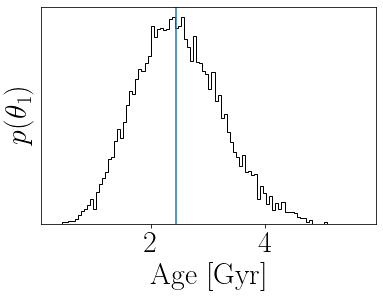

In [57]:
samples = sampler.get_chain(flat=True)
median_age = np.median((10**samples)*1e-9)
print(median_age)

plt.hist((10**samples)*1e-9, 100, color="k", histtype="step")
plt.axvline(median_age)
plt.xlabel(r"$\mathrm{Age~[Gyr]}$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);